In [1]:
from langgraph.graph import StateGraph,START,END
from typing import TypedDict,Annotated,Literal
import os
from langchain_google_genai import ChatGoogleGenerativeAI  
from dotenv import load_dotenv
from pydantic import BaseModel, Field

In [2]:
load_dotenv()

True

In [3]:
def create_llm():
    api_key=os.getenv("GOOGLE_API_KEY")

    llm=ChatGoogleGenerativeAI(model="gemini-1.5-flash",
                               api_key=api_key)
    
    return llm

In [4]:
model=create_llm()

In [5]:
class Schema(BaseModel):

    sentiment:Literal['positive','negative']=Field(description="sentiment of the review")
    

In [12]:
class diagnosis(BaseModel):

    issue_type:Literal['product','service','delivery','other']=Field(description="type of issue in the review")
    tone:Literal['angry','sad','neutral','happy']=Field(description="tone of the review")
    urgency:Literal['high','medium','low']=Field(description="urgency of the review")

In [13]:
structured_model=model.with_structured_output(Schema)
structured_model_2=model.with_structured_output(diagnosis)

In [7]:
class reviewhandler(TypedDict):

    review:str

    sentiment:Literal['positive','negative']
    diagonisis:dict

    response:str

In [8]:
def find_sentiment(state:reviewhandler):

    prompt=f"For the Following review find the Sentiment as poitive or negative:\n {state['review']}"
    sentiment=structured_model.invoke(prompt).sentiment

    return {"sentiment":sentiment}

In [9]:
def condition(state:reviewhandler)->Literal["positive_response","run_diagonisis"]:
    if state['sentiment']=='positive':
        return "positive_response"
    else:
        return "run_diagonisis"
    

In [14]:
def run_diagonisis(state:reviewhandler):

    prompt=f"Run the diagnosis of the Review {state['review']} and return issue_type,tone and urgency"

    diagonisis=structured_model_2.invoke(prompt)

    return {"diagonisis":diagonisis.model_dump()}

In [15]:
def negative_response(state:reviewhandler):

    prompt=f"You are a support agent. Write a empathetic response to the following negative review:\n {state['review']}\n The issue type is {state['diagonisis']['issue_type']}, the tone is {state['diagonisis']['tone']} and the urgency is {state['diagonisis']['urgency']}"

    response=model.invoke(prompt).content

    return {'response':response}
    

In [11]:
def positive_response(state:reviewhandler):
    
    prompt=f"Write a positive response to the following review:\n {state['review']}"

    response=model.invoke(prompt).content

    return {'response':response}

In [17]:
graph=StateGraph(reviewhandler)

graph.add_node("find_sentiment",find_sentiment)
graph.add_node("run_diagonisis",run_diagonisis)
graph.add_node("negative_response",negative_response)
graph.add_node("positive_response",positive_response)

graph.add_edge(START,"find_sentiment")
graph.add_conditional_edges("find_sentiment",condition)
graph.add_edge("positive_response",END)
graph.add_edge("run_diagonisis","negative_response")
graph.add_edge("negative_response",END)


workflow=graph.compile()


In [23]:
initial_state={"review":"The product quality is terrible and the delivery was late. I'm very disappointed with my purchase."}

result=workflow.invoke(initial_state)

print(result)

{'review': "The product quality is terrible and the delivery was late. I'm very disappointed with my purchase.", 'sentiment': 'negative', 'diagonisis': {'issue_type': 'product', 'tone': 'sad', 'urgency': 'low'}, 'response': "I'm so sorry to hear about your disappointing experience with your recent purchase.  We truly appreciate you bringing this to our attention, and I understand how frustrating it must be to receive a product of poor quality and after a delayed delivery.  It's certainly not the experience we aim to provide our customers.\n\nCould you please tell me a little more about the specific issues you encountered with the product quality?  Knowing the details will help us understand what went wrong and prevent similar problems in the future.  Also, if you could provide your order number, it would allow me to investigate the delivery delay as well.\n\nWe want to make things right for you.  Depending on the specifics, we may be able to offer a replacement, a refund, or another fo

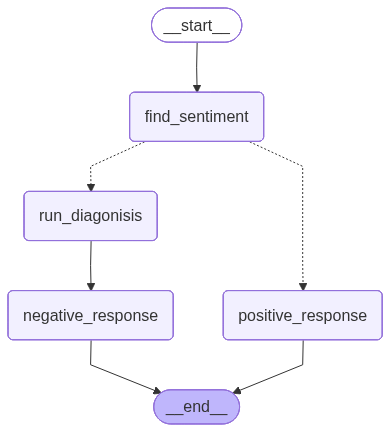

In [18]:
from IPython.display import Image, display

try:
    display(Image(workflow.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass